In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
import os
import time

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.
            writeTask.write(voltages)

            writeTask.start()
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        """
        Geneate a waveform from the 4 basic wave parameters

        Parameters
        ----------
        function : str or callable
            Type of waveform. The parameters `amplitude`, `frequency` and `phase`
            are passed to the callable.
        samplerate: int
            Samplerate with which to sample waveform.
        frequency : int or float
            Frequency of the waveform.
        amplitude : int or float, optional
            Amplitude of the waveform in volts. The default is 1.
        phase : int or float, optional
            Phase of the waveform in degrees. The default is 0.
        duration : int or float, optional
            Duration of the waveform in seconds. The default is 1.
        phaseInDegrees: bool, optional
            Whether phase is given in degrees. The default is True

        Returns
        -------
        timeArray : ndarray
            ndarray containing the discrete times at which the waveform is evaluated.
        wave : ndarray
            ndarray of the evaluated waveform.

        """
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)


    @staticmethod
    def performRFFT(data: np.ndarray, samplerate : int, norm='forward'):

        complex_coefficients = rfft(data, norm=norm)
        frequencies = rfftfreq(len(data), 1 / samplerate)
        if norm =='forward':
            complex_coefficients[1:-1] *= 2  # Correct scaling to show accurate 
        
        if norm =='backward':
            pass
        return frequencies, complex_coefficients
    
    @staticmethod
    def performIRFFT(complex_coefficients, norm='forward'):
        complex_coefficients[1:-1] /= 2    
        original_data = irfft(complex_coefficients, norm=norm)    
        return original_data
    

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    

    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    









In [3]:
daq = MyDAQ()

daq.name = 'MyDAQ1'
samplerate = 100
daq.samplerate = samplerate
duration = 2  # seconds

read_channel = 'AI0'
#daq._addInputChannels(task=dx.Task(), channels='AI0')
#daq._configureChannelTimings
data = daq.read(duration, read_channel)

np.savetxt('Input_from_func.txt', data)

c:\Users\damia\anaconda3\Lib\site-packages\nidaqmx\task\_task.py:98: DaqResourceWarning: Task of name "_unnamedTask<0>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


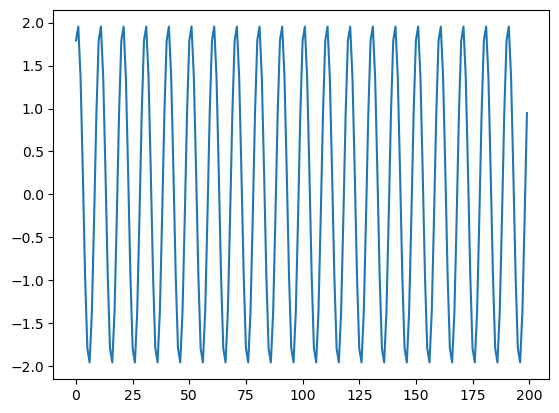

In [63]:
plt.plot(data)

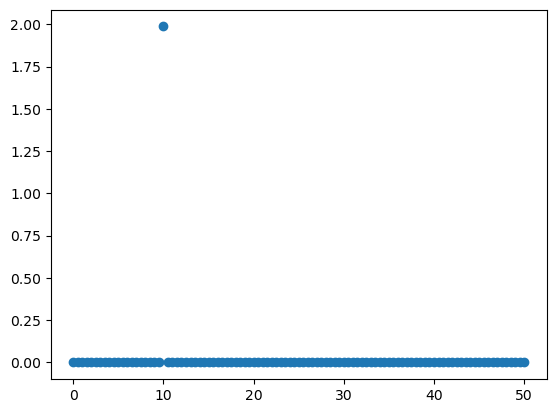

In [64]:
freq, coef = daq.performRFFT(data=data, samplerate=samplerate)

plt.scatter(freq, np.abs(coef))

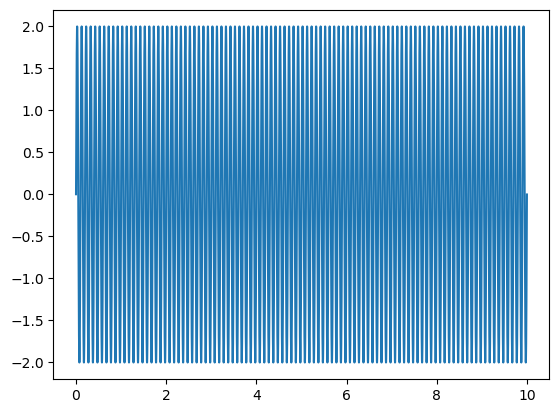

In [9]:
samplerate = 44000
daq.samplerate = samplerate
frequency =  10
duration = 10
x, y= daq.generateWaveform(function='sine', samplerate=samplerate, frequency=frequency, duration=duration, amplitude=2, phase=0) 

plt.plot(x,y)
plt.show()
write_channel = 'AO0'

daq.write(y, write_channel)

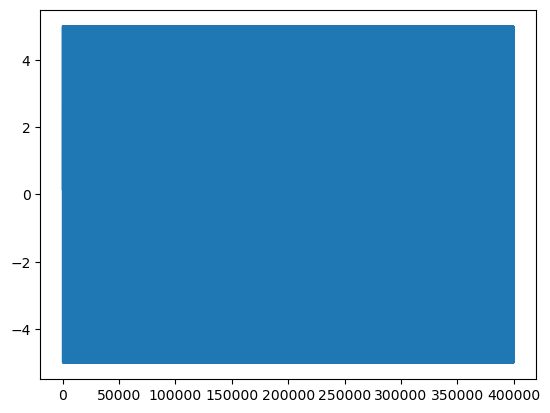

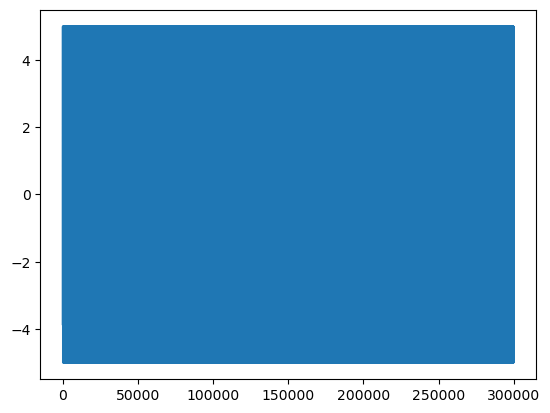

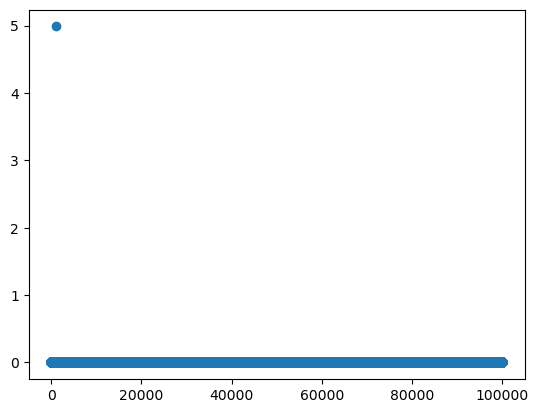

In [42]:
samplerate = 200000
daq.samplerate = samplerate
frequency =  1000
duration = 2
x, y= daq.generateWaveform(function='sine', samplerate=samplerate, frequency=frequency, duration=duration, amplitude=5, phase=0) 

plt.plot(y)
plt.show()
read_channel = 'AI0'
write_channel = 'AO0'
data = daq.readwrite(y, read_channel, write_channel)
# Calculate the index for 3/4 of the array
three_quarters_index = int(len(data) * 3 / 4)

# Get the first 3/4 of the array
data = data[:three_quarters_index]

np.savetxt('readWriteTest.txt', data)

plt.plot(data)
plt.show()
freq, coef = daq.performRFFT(data=data, samplerate=samplerate)

plt.scatter(freq, np.abs(coef))
plt.show()

In [51]:
end_frequency = 99000
begin_frequency = 1
number_of_points = 1000
frequencies = np.linspace(begin_frequency, end_frequency, number_of_points)

samplerate = 200000
duration = 1
daq.samplerate = samplerate
read_channel = 'AI0'
write_channel = 'AO0'
for frequency in frequencies:
    _, y= daq.generateWaveform(function='sine', samplerate=samplerate, frequency=frequency, duration=duration, amplitude=5, phase=0) 

    data = daq.readwrite(y, read_channel, write_channel)
    # Calculate the index for 3/4 of the array

    np.savetxt(f'data/frequency_{frequency}.txt', data)


done with 1.0
done with 100.09809809809809
done with 199.19619619619618
done with 298.2942942942943
done with 397.39239239239237
done with 496.49049049049046
done with 595.5885885885886
done with 694.6866866866867
done with 793.7847847847847
done with 892.8828828828828
done with 991.9809809809809
done with 1091.079079079079
done with 1190.177177177177
done with 1289.2752752752751
done with 1388.3733733733734
done with 1487.4714714714714
done with 1586.5695695695695
done with 1685.6676676676675
done with 1784.7657657657655
done with 1883.8638638638638
done with 1982.9619619619618
done with 2082.06006006006
done with 2181.158158158158
done with 2280.256256256256
done with 2379.354354354354
done with 2478.4524524524522
done with 2577.5505505505503
done with 2676.6486486486483
done with 2775.746746746747
done with 2874.844844844845
done with 2973.942942942943
done with 3073.041041041041
done with 3172.139139139139
done with 3271.237237237237
done with 3370.335335335335
done with 3469.43343

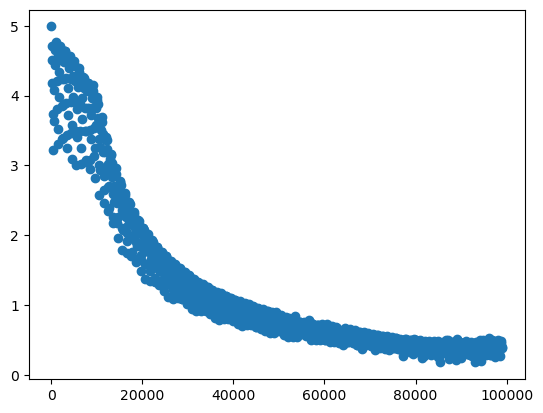

In [18]:
end_frequency = 99000
begin_frequency = 1
number_of_points = 1000
frequencies = np.linspace(begin_frequency, end_frequency, number_of_points)

daq = MyDAQ()
samplerate = 200000
H = []

for frequency in frequencies:
    freq, coef = daq.performRFFT(data=np.loadtxt(f'data/frequency_{frequency}.txt'), samplerate=samplerate)
    H_value = np.max(np.abs(coef))
    H.append(H_value)
    print(f'done with {frequency}')

plt.scatter(frequencies, H)

    

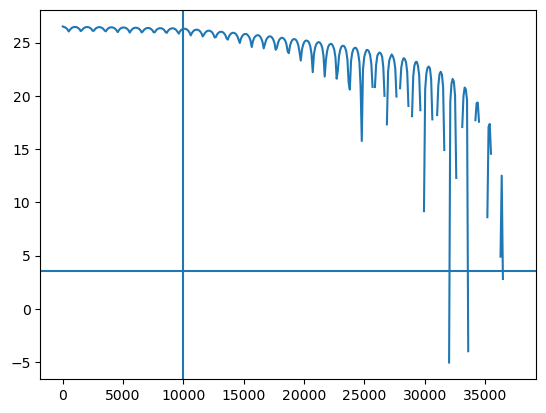

In [30]:
plt.plot(frequencies, H)
plt.axhline(5*0.71)
plt.axvline(10000)


C:\Users\damia\AppData\Local\Temp\ipykernel_11020\1780026252.py:1: RuntimeWarning: invalid value encountered in log10
  H_new = 20* np.log10(H)


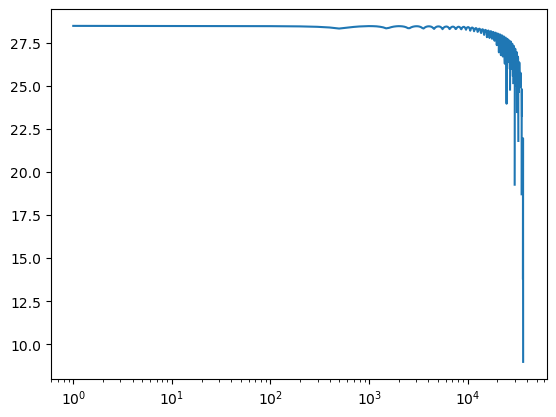

In [29]:
H_new = 20* np.log10(H)
plt.plot(frequencies, H_new)
plt.xscale('log')